In [75]:
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from numpy import linalg
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_random_state
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
df = pd.read_csv('../dataset/data_7diagnosis.csv')
df_quantitatifs = df.drop(columns="Diagnosis")

## Fonctions utils (TP SY09)

Car import ne fonctionne pas très bien

In [76]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_markerfacecolor()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], angle=180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca

class AdaptiveKMeans(ClusterMixin, BaseEstimator):
    def __init__(self, n_clusters=8, n_init=10, tol=1e-4, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = check_random_state(random_state)

    def fit(self, X):
        X = check_array(X)

        n, p = X.shape
        n_init = self.n_init
        n_clusters = self.n_clusters
        max_iter = self.max_iter
        tol = self.tol

        centers_opt = None
        Vt_opt = None
        partition_opt = None
        d_opt = float("inf")

        for i in range(n_init):
            # Extraction des `n_clusters` centres pris aléatoirement
            # dans `X`. On utilisera `self.random_state.choice`.
            # <answer>
            centers_idx = self.random_state.choice(n, size=n_clusters, replace=False)
            centers = X[centers_idx, :]
            # </answer>

            # Initialisation des matrices de variance--covariance
            # brutes et normalisées
            # <answer>
            Vt = [np.eye(p) for i in range(n_clusters)]
            Vt_norm = [np.eye(p) for i in range(n_clusters)]
            # </answer>

            step = tol + 1
            it = 0

            while step > tol and it < max_iter:
                old_centers = centers

                # Calcul d'une nouvelle partition
                dist = np.concatenate(
                    [
                        cdist(c[None, :], X, metric="mahalanobis", VI=linalg.inv(V))
                        for c, V in zip(centers, Vt_norm)
                    ]
                )
                partition = np.argmin(dist, axis=0)

                # Mise à jour des paramètres
                for k in range(n_clusters):
                    # Extraction des individus de class k
                    # <answer>
                    Xk = X[partition == k, :]
                    # </answer>

                    # On évite les groupements dégénérés (trop peu de
                    # points pour inverser la matrice de
                    # variance--covariance empirique)
                    if Xk.shape[0] >= p:
                        # Calcul du k-ième centre
                        # <answer>
                        centers[k, :] = np.mean(Xk, axis=0)
                        # </answer>

                        # Calcul de la k-ième matrice de
                        # variance-covariance avec `np.cov`
                        # <answer>
                        c = np.cov(Xk, bias=True, rowvar=False)
                        # </answer>

                        # Régularisation de la matrice de covariance :
                        # on grossit la diagonale pour rendre la
                        # matrice inversible quoi qu'il arrive.
                        c += 1e-5 * np.eye(c.shape[0])
                        Vt[k] = c

                        # Calcul de la matrice de variance-covariance
                        # normalisée avec `linalg.det`
                        # <answer>
                        Vt_norm[k] = (linalg.det(c)) ** (-1 / p) * c
                        # </answer>

                step = ((old_centers - centers) ** 2).sum()
                it += 1

            # Calcul de `d_tot`. On pourra s'inspirer des instructions
            # permettant de calculer `dist` (voir plus haut).
            # <answer>
            d_tot = sum(
                (
                    cdist(
                        c[None, :],
                        X[partition == k, :],
                        metric="mahalanobis",
                        VI=linalg.inv(V),
                    )
                    ** 2
                ).sum()
                for k, (c, V) in enumerate(zip(centers, Vt_norm))
            )
            # </answer>

            # Mise à jour du modèle optimal si besoin
            if d_tot < d_opt:
                centers_opt = centers
                Vt_opt = Vt
                Vt_norm_opt = Vt_norm
                partition_opt = partition
                d_opt = d_tot

        self.labels_ = partition_opt
        self.cluster_centers_ = centers_opt
        self.covars_ = Vt_opt
        self.covars_norm_ = Vt_norm_opt
        self.d_opt = d_opt

## Kmeans

3622.8680164598427


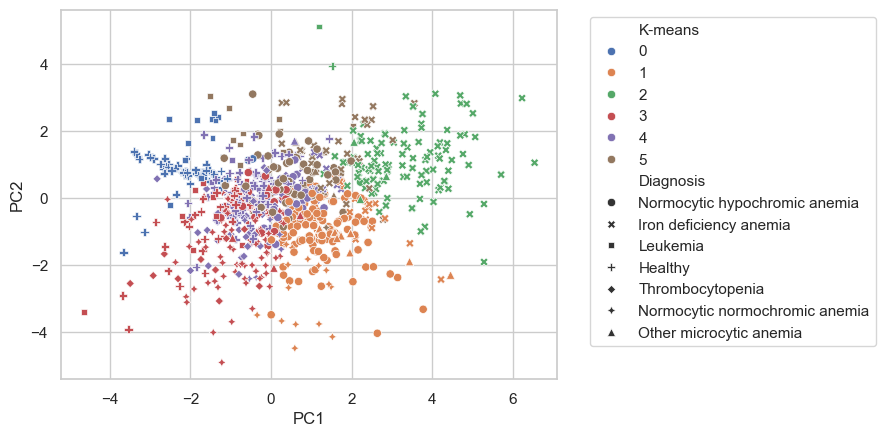

In [101]:
sns.set(style="whitegrid")
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_quantitatifs), columns = df_quantitatifs.columns)

cls = KMeans(n_clusters=6, init="k-means++",n_init=20)
cls.fit(X)

labels = pd.Series(cls.labels_, name="K-means")
scatterplot_pca(data=X, hue=labels, style=df.Diagnosis)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Indice de Rand

In [102]:
ari = adjusted_rand_score(df['Diagnosis'], cls.labels_)
print(f"L'indice de Rand ajusté est : {ari * 100} %")

L'indice de Rand ajusté est : 44.56868918156518 %


## Adaptive Kmeans

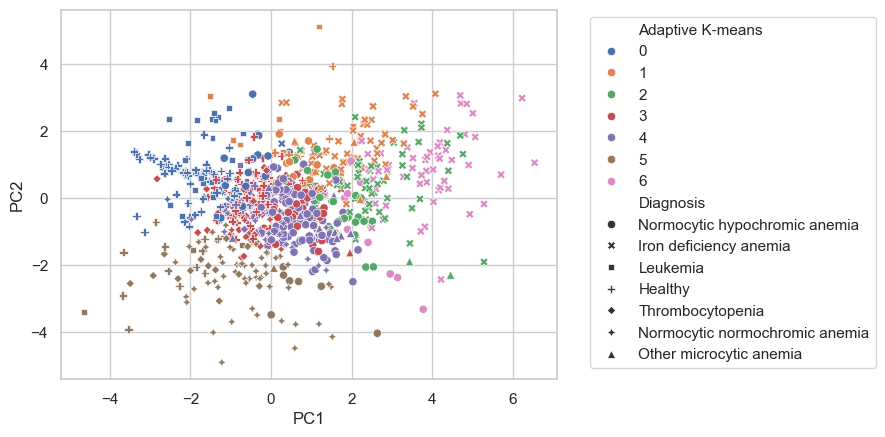

In [78]:
cls = AdaptiveKMeans(n_clusters=7)
labels=cls.fit_predict(X.to_numpy())
labels = pd.Series(labels, name="Adaptive K-means")
scatterplot_pca(data=X, hue=labels, style=df.Diagnosis)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Indice de Rand Adaptive

In [79]:
ari = adjusted_rand_score(df['Diagnosis'], cls.labels_)
print(f"L'indice de Rand ajusté est : {ari * 100} %")

L'indice de Rand ajusté est : 27.188181800405708 %


## Indice de Rand et Inertie selon le nombre de clusters

C:\Users\felic\AppData\Local\Temp\ipykernel_14544\2013844382.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="n_clusters",y="rand",data=df_kmean.loc[df_kmean.init == "k-means++"],err_style="bars",ci="sd")


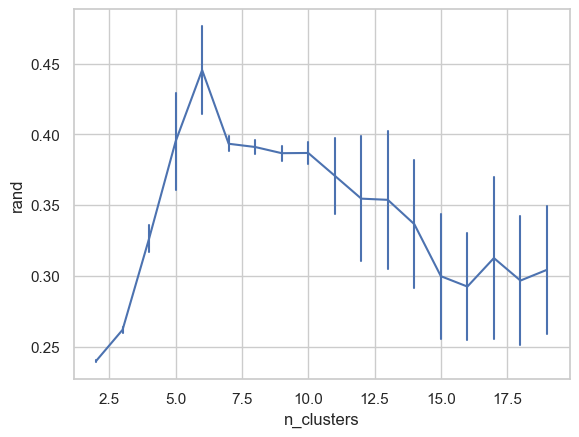

C:\Users\felic\AppData\Local\Temp\ipykernel_14544\2013844382.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="n_clusters",y="inertia",data=df_kmean.loc[df_kmean.init == "k-means++"],err_style="bars",ci="sd")


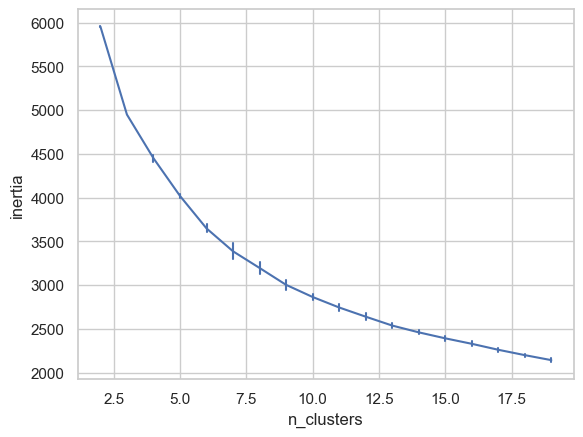

In [80]:
def kmeans_dataset(dataset, n_clusters_list, strategies, tries):
    for n_clusters in n_clusters_list:
        for strategy in strategies:
            for rs in range(tries):
                inertia = (
                    KMeans(n_clusters=n_clusters,n_init=10, random_state=rs,init=strategy).fit(dataset).inertia_)
                rand = adjusted_rand_score(df['Diagnosis'], KMeans(n_clusters=n_clusters,n_init=10, random_state=rs,init=strategy).fit(dataset).labels_)
                yield rs, strategy, n_clusters, inertia, rand

gen=kmeans_dataset(X,range(2,20),["k-means++"],20)
df_kmean=pd.DataFrame(gen, columns=["seed", "init", "n_clusters","inertia","rand"])
sns.lineplot(x="n_clusters",y="rand",data=df_kmean.loc[df_kmean.init == "k-means++"],err_style="bars",ci="sd")
plt.show()
sns.lineplot(x="n_clusters",y="inertia",data=df_kmean.loc[df_kmean.init == "k-means++"],err_style="bars",ci="sd")
plt.show()

C:\Users\felic\AppData\Local\Temp\ipykernel_14544\3943688800.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="n_clusters",y="rand",data=df_kmean.loc[df_kmean.init == "k-means++"],err_style="bars",ci="sd")


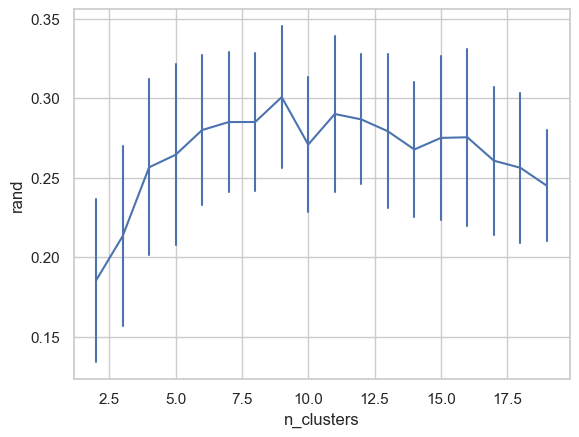

In [87]:
def kmeansadaptive_dataset(dataset, n_clusters_list, strategies, tries):
    for n_clusters in n_clusters_list:
        for strategy in strategies:
            for rs in range(tries):
                label=AdaptiveKMeans(n_clusters=n_clusters,n_init=10, random_state=rs).fit_predict(dataset.to_numpy())
                rand = adjusted_rand_score(df['Diagnosis'],label)
                yield rs, strategy, n_clusters, rand

gen=kmeansadaptive_dataset(X,range(2,20),["k-means++"],20)
df_kmean=pd.DataFrame(gen, columns=["seed", "init", "n_clusters","rand"])
sns.lineplot(x="n_clusters",y="rand",data=df_kmean.loc[df_kmean.init == "k-means++"],err_style="bars",ci="sd")
plt.show()

## Kmeans sur ACP directement

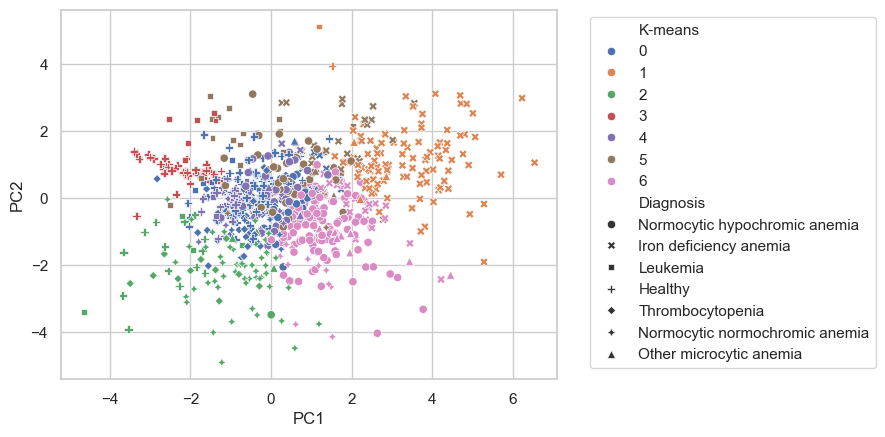

L'indice de Rand ajusté est : 39.50415969508171 %


In [100]:

X = pd.DataFrame(scaler.fit_transform(df_quantitatifs), columns = df_quantitatifs.columns)
pca = PCA(n_components=7)
pcs = pca.fit_transform(X)
pca_df = pd.DataFrame(pcs,columns=[f"PC{i}" for i in range(1, 8)])
cls = KMeans(n_clusters=7, init="k-means++",n_init=20)
cls.fit(pca_df)

labels = pd.Series(cls.labels_, name="K-means")
scatterplot_pca(data=pca_df, hue=labels, style=df.Diagnosis)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
ari = adjusted_rand_score(df['Diagnosis'], cls.labels_)
print(f"L'indice de Rand ajusté est : {ari * 100} %")